<a href="https://colab.research.google.com/github/shubhanshu1995/Deep-Learning-with-Keras/blob/master/VGG16_Model_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Kaggle Datasets/dogs-vs-cats/data/train'
valid_path = '/content/gdrive/My Drive/Colab Notebooks/Kaggle Datasets/dogs-vs-cats/data/validation'
test_path = '/content/gdrive/My Drive/Colab Notebooks/Kaggle Datasets/dogs-vs-cats/data/test'

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224), classes=['dogs','cats'],batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224), classes=['dogs','cats'],batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224), classes=['dogs','cats'],batch_size=10)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
#plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims = np.array(ims).astype(np.uint8)
    if (ims.shape[-1]!=3):
      ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else  len(ims)//rows + 1
    for i in range(len(ims)):
      sp = f.add_subplot(rows, cols, i+1)
      sp.axis('Off')
      if titles is not None:
        sp.set_title(titles[i], fontsize=16)
      plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
imgs, labels = next(train_batches)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


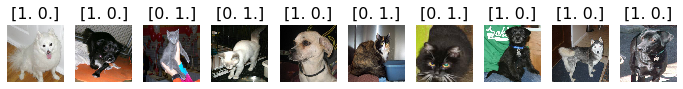

In [7]:
plots(imgs,titles=labels)

In [8]:
from keras import backend
print(backend.image_data_format())
print(train_batches.class_indices)

channels_last
{'dogs': 0, 'cats': 1}


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#**Build Fine-tuned VGG16 model**

In [10]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 3s 0us/step


In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

## **The last output layer of VGG16 model classify images into 1000 categories. We don't want that. So we don't add the last dense layer**

In [13]:
new_model = Sequential()
for layer in vgg16_model.layers[:-1]:
  new_model.add(layer)

In [14]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# **Freezing a layer meaning that we are excluding it from future training. Weights will never be updated. This is useful for the purpose of fine tuning the model.**

In [15]:
for layer in new_model.layers:
    layer.trainable = False        

In [16]:
new_model.add(Dense(2,activation='softmax'))

In [17]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# **Train the fine-tuned VGG16 model**

In [18]:
new_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
new_model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=10, verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
4/4 - 12s - loss: 1.2184 - accuracy: 0.5750 - val_loss: 1.3152 - val_accuracy: 0.4375
Epoch 2/10
4/4 - 14s - loss: 1.4536 - accuracy: 0.5750 - val_loss: 0.4753 - val_accuracy: 0.8125
Epoch 3/10
4/4 - 13s - loss: 0.5308 - accuracy: 0.6500 - val_loss: 0.2530 - val_accuracy: 0.8125
Epoch 4/10
4/4 - 10s - loss: 0.5730 - accuracy: 0.8000 - val_loss: 0.3115 - val_accuracy: 0.8750
Epoch 5/10
4/4 - 13s - loss: 0.3435 - accuracy: 0.8500 - val_loss: 0.6009 - val_accuracy: 0.6250
Epoch 6/10
4/4 - 11s - loss: 0.4772 - accuracy: 0.7750 - val_loss: 0.6732 - val_accuracy: 0.6250
Epoch 7/10
4/4 - 12s - loss: 0.4041 - accuracy: 0.8500 - val_loss: 0.2755 - val_accuracy: 0.9375
Epoch 8/10
4/4 - 11s - loss: 0.3592 - accuracy: 0.9000 - val_loss: 0.3874 - val_accuracy: 0.7500
Epoch 9/10
4/4 - 11s - loss: 0.3609 - accuracy: 0.9000 - val_loss: 0.1359 - val_accuracy: 0.9375
Epoch 10/10
4/4 - 11s - loss: 0.5901 - accuracy: 0.

## **Predict using fine-tuned VGG16 model**

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


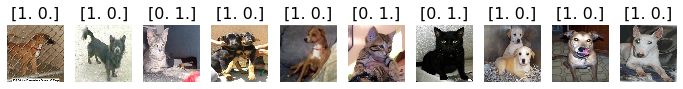

In [20]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [21]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 1., 1., 0., 0., 1., 1., 1.], dtype=float32)

In [32]:
predictions = new_model.predict_generator(test_batches, steps=1, verbose=0)

In [33]:
new_cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[3 0]
 [3 4]]


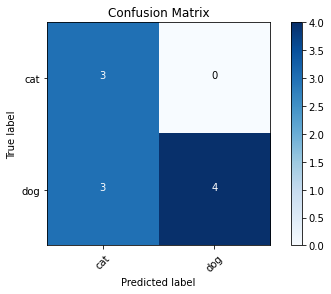

In [34]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(new_cm, cm_plot_labels, title='Confusion Matrix')

L1 norm conv layer 1
 [('filt_24', 1.6175919), ('filt_32', 1.8250046), ('filt_40', 2.4310503), ('filt_2', 2.495041), ('filt_52', 2.651238), ('filt_39', 2.7336175), ('filt_50', 2.7599242), ('filt_36', 2.7751088), ('filt_55', 2.8363388), ('filt_61', 2.9448466), ('filt_31', 3.0375495), ('filt_17', 3.0668314), ('filt_22', 3.107742), ('filt_13', 3.1842504), ('filt_44', 3.1984107), ('filt_16', 3.205396), ('filt_9', 3.2545583), ('filt_33', 3.270072), ('filt_1', 3.2756076), ('filt_56', 3.30176), ('filt_27', 3.3258128), ('filt_6', 3.3452435), ('filt_38', 3.3973157), ('filt_29', 3.426872), ('filt_11', 3.57709), ('filt_19', 3.6452098), ('filt_25', 3.6796942), ('filt_46', 3.8066206), ('filt_42', 3.877387), ('filt_15', 3.960729), ('filt_7', 4.0549836), ('filt_30', 4.1647773), ('filt_18', 4.3078637), ('filt_53', 4.5156593), ('filt_59', 4.601973), ('filt_5', 4.602416), ('filt_20', 4.643106), ('filt_48', 4.8627605), ('filt_54', 4.867883), ('filt_4', 4.989608), ('filt_57', 5.1788306), ('filt_8', 5.2600

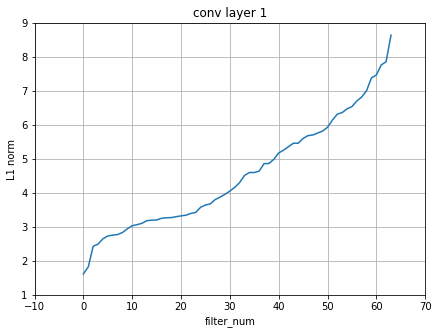

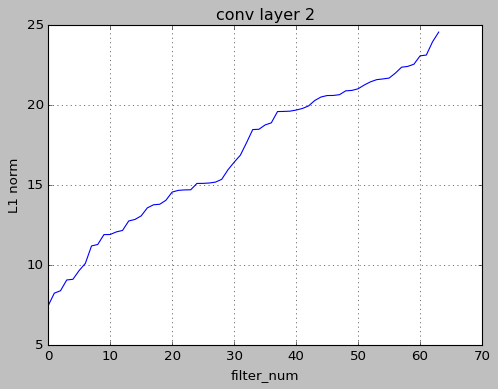

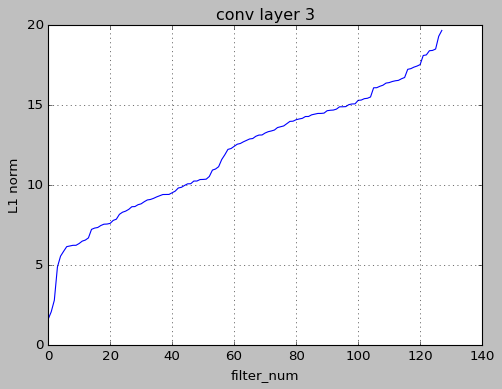

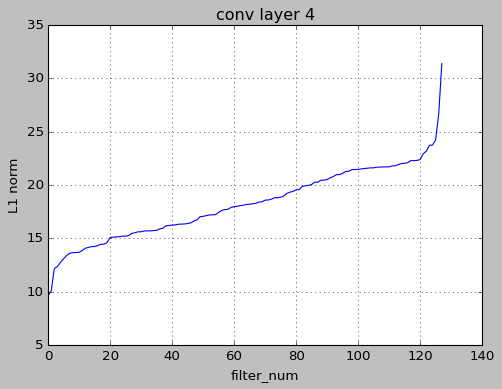

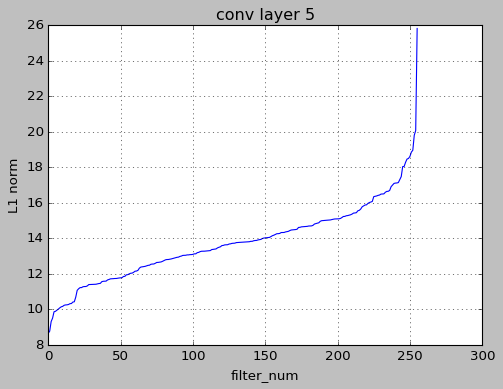

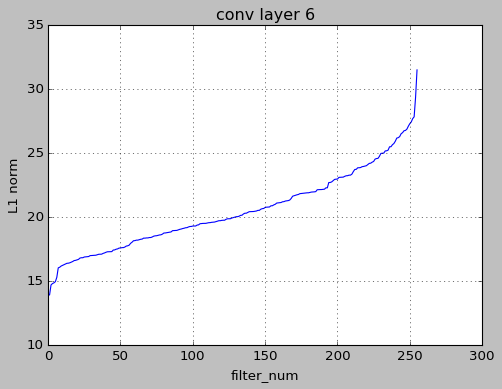

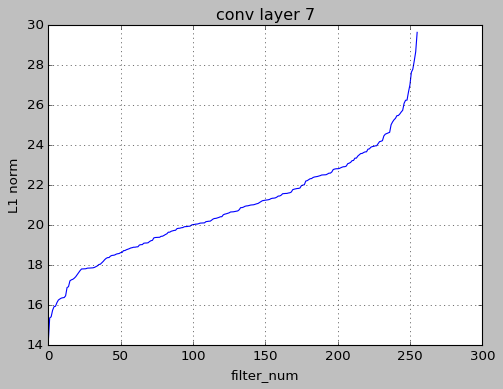

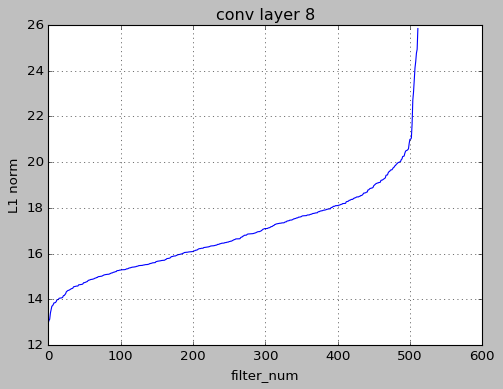

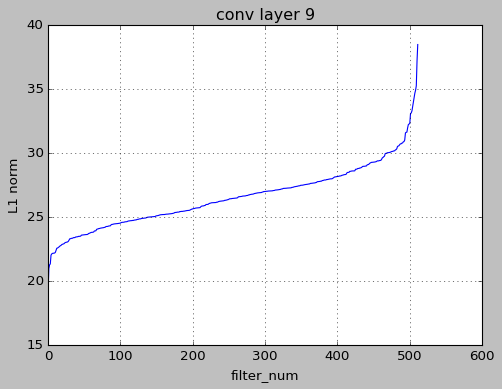

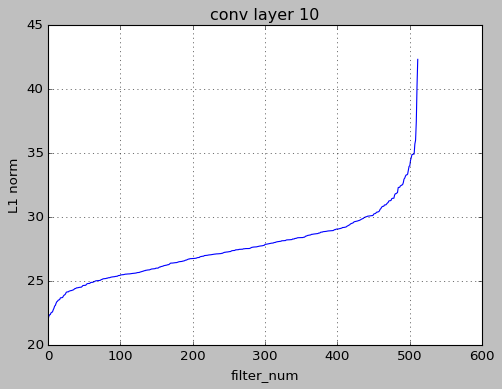

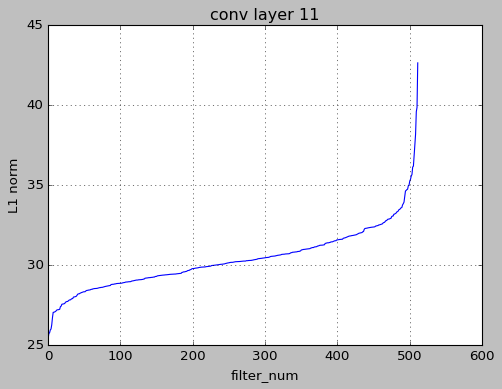

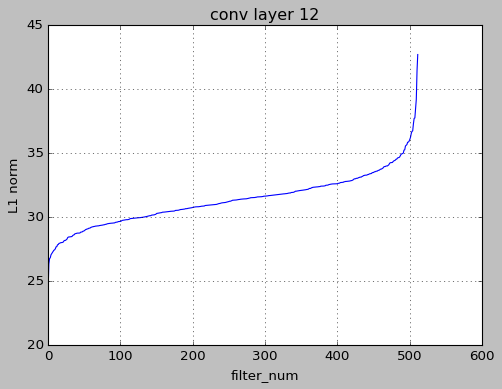

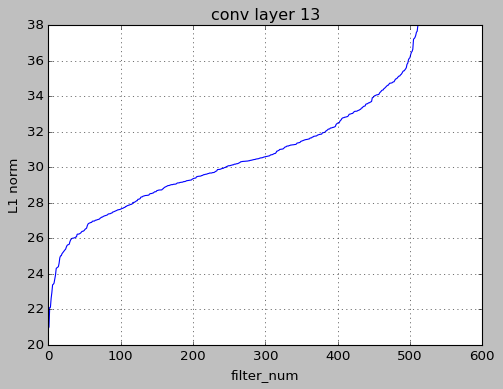

In [35]:
#Computing L1 norm of filter weights
w1 = new_model.layers[0].get_weights()[0]
w2 = new_model.layers[1].get_weights()[0]
w3 = new_model.layers[3].get_weights()[0]
w4 = new_model.layers[4].get_weights()[0]
w5 = new_model.layers[6].get_weights()[0]
w6 = new_model.layers[7].get_weights()[0]
w7 = new_model.layers[8].get_weights()[0]
w8 = new_model.layers[10].get_weights()[0]
w9 = new_model.layers[11].get_weights()[0]
w10 = new_model.layers[12].get_weights()[0]
w11 = new_model.layers[14].get_weights()[0]
w12 = new_model.layers[15].get_weights()[0]
w13 = new_model.layers[16].get_weights()[0]


conv_layer_weights = [w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13]

conv_layer_dict = {}
for i in range(len(conv_layer_weights)):
  weight = conv_layer_weights[i]
  weights_dict = {}
  num_filters = len(weight[0,0,0,:])
   
  # computing L1 norm of each filter weight and store it in a dictionary
  for j in range(num_filters):
    w_s = np.sum(abs(weight[:,:,:,j]))
    filt = "filt_{}".format(j)
    weights_dict[filt] = w_s

  # sort the filter as per their ascending L1 value
  weights_dict_sort = sorted(weights_dict.items(),key=lambda kv: kv[1])
  print("L1 norm conv layer {}\n".format(i+1),weights_dict_sort)

  #get the L1 norm of weights from the dictionary and plot it
  weights_value = []
  for elem in weights_dict_sort:
    weights_value.append(elem[1])
    conv_layer_dict.setdefault(i+1, []).append(int(elem[0].split("_")[-1]))
  
  xc = range(num_filters)

  plt.figure(i+1,figsize=(7,5))
  plt.plot(xc,weights_value)
  plt.xlabel("filter_num")
  plt.ylabel("L1 norm")
  plt.title("conv layer {}".format(i+1))
  plt.grid(True)
  plt.style.use(["classic"])

# **Scenario 1:**
## Removing filters from convolution layer -1 which has 64 filters

## Removing 10 filters with the least L1-norm using keras-surgeon in the below code

In [36]:
!pip install kerassurgeon

     |████████████████████████████████| 2.2MB 11.1MB/s 
     |████████████████████████████████| 276kB 42.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: importlib-metadata 2.0.0
    Uninstalling importlib-metadata-2.0.0:
      Successfully uninstalled importlib-metadata-2.0.0
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [37]:
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels, delete_layer

layer_0 = new_model.layers[0] #conv layer 1
pruned_model_1 = delete_channels(new_model,layer_0,conv_layer_dict[1][:10])
pruned_model_1.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Deleting 10/64 channels from layer: block1_conv1


In [40]:
score = new_model.evaluate(test_batches)

20/20 [==============================] - 1s 56ms/step - loss: 0.3329 - accuracy: 0.8650


In [41]:
score = pruned_model_1.evaluate(test_batches)

20/20 [==============================] - 1s 55ms/step - loss: 0.3291 - accuracy: 0.8600


In [92]:
pruned_model_1_predictions = pruned_model_1.predict_generator(test_batches, steps=1, verbose=0)

In [93]:
pruned_model_1_cm = confusion_matrix(test_labels, np.round(pruned_model_1_predictions[:,0]))

Confusion matrix, without normalization
[[1 2]
 [3 4]]


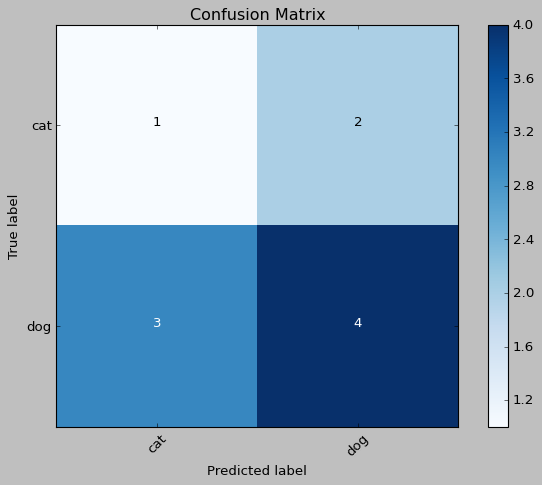

In [94]:
plot_confusion_matrix(pruned_model_1_cm, cm_plot_labels, title='Confusion Matrix')

In [42]:
new_model.save("new_model.h5") ## original vgg16 model
pruned_model_1.save("pruned_model_1.h5") ## pruned vgg16 model

In [43]:
pruned_model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 54)      1512      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      31168     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      



*   **In the above code snippet of pruned_model_1 summary, Total params: 134,262,698**
*   **Total params in previous vgg16 new_model: 134,268,738**

*   **So by pruning here, accuracy dropped slightly and total params got reduced by 6040 numbers.**







# **Scenario 2:**
## Now Removing 20 filters from first convolution layer with least L1 Norm

In [44]:
pruned_model_2 = delete_channels(new_model,layer_0,conv_layer_dict[1][:20])
pruned_model_2.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Deleting 20/64 channels from layer: block1_conv1


In [45]:
pruned_model_2.save("pruned_model_2.h5") ## pruned vgg16 model

In [46]:
score = pruned_model_2.evaluate(test_batches)

20/20 [==============================] - 1s 54ms/step - loss: 0.3176 - accuracy: 0.8500


In [95]:
pruned_model_2_predictions = pruned_model_2.predict_generator(test_batches, steps=1, verbose=0)

In [96]:
pruned_model_2_cm = confusion_matrix(test_labels, np.round(pruned_model_2_predictions[:,0]))

Confusion matrix, without normalization
[[1 2]
 [3 4]]


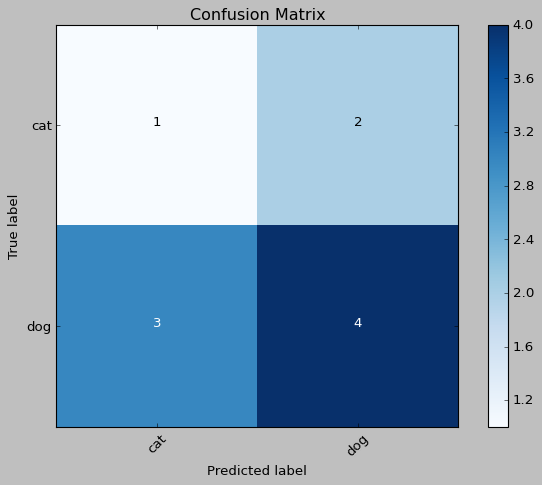

In [97]:
plot_confusion_matrix(pruned_model_2_cm, cm_plot_labels, title='Confusion Matrix')

In [47]:
pruned_model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 44)      1232      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      25408     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      



*   **In the above code snippet of pruned_model_2 summary, Total params: 134,256,658**
*   **Total params in previous vgg16 new_model: 134,268,738**

*   **So by pruning here, accuracy dropped slightly and total params got reduced by 12,080 numbers.**







# **Scenario 3:**
## Now Removing 10 filters from all convolution layers with least L1 Norm

In [48]:
from kerassurgeon import Surgeon

layer_0 = new_model.layers[0] #conv layer 1
layer_1 = new_model.layers[1] #conv layer 2
layer_3 = new_model.layers[3] #conv layer 3
layer_4 = new_model.layers[4] #conv layer 4
layer_6 = new_model.layers[6] #conv layer 5
layer_7 = new_model.layers[7] #conv layer 6
layer_8 = new_model.layers[8] #conv layer 7
layer_10 = new_model.layers[10] #conv layer 8
layer_11 = new_model.layers[11] #conv layer 9
layer_12 = new_model.layers[12] #conv layer 10
layer_14 = new_model.layers[14] #conv layer 11
layer_15 = new_model.layers[15] #conv layer 12
layer_16 = new_model.layers[16] #conv layer 13

conv_layers_list = [layer_0,layer_1,layer_3,layer_4,layer_6,
                    layer_7,layer_8,layer_10,layer_11,layer_12,
                    layer_14,layer_15,layer_16]

surgeon = Surgeon(new_model)

for idx,item in enumerate(conv_layers_list):
  surgeon.add_job("delete_channels",item,channels=conv_layer_dict[idx+1][:10])

pruned_model_3 = surgeon.operate()
pruned_model_3.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Deleting 10/64 channels from layer: block1_conv1
Deleting 10/64 channels from layer: block1_conv2
Deleting 10/128 channels from layer: block2_conv1
Deleting 10/128 channels from layer: block2_conv2
Deleting 10/256 channels from layer: block3_conv1
Deleting 10/256 channels from layer: block3_conv2
Deleting 10/256 channels from layer: block3_conv3
Deleting 10/512 channels from layer: block4_conv1
Deleting 10/512 channels from layer: block4_conv2
Deleting 10/512 channels from layer: block4_conv3
Deleting 10/512 channels from layer: block5_conv1
Deleting 10/512 channels from layer: block5_conv2
Deleting 10/512 channels from layer: block5_conv3


In [49]:
pruned_model_3.save("pruned_model_3.h5") ## pruned vgg16 model

In [51]:
score = pruned_model_3.evaluate(test_batches)

20/20 [==============================] - 1s 55ms/step - loss: 0.4406 - accuracy: 0.7900


In [98]:
pruned_model_3_predictions = pruned_model_3.predict_generator(test_batches, steps=1, verbose=0)

In [99]:
pruned_model_3_cm = confusion_matrix(test_labels, np.round(pruned_model_3_predictions[:,0]))

Confusion matrix, without normalization
[[2 1]
 [7 0]]


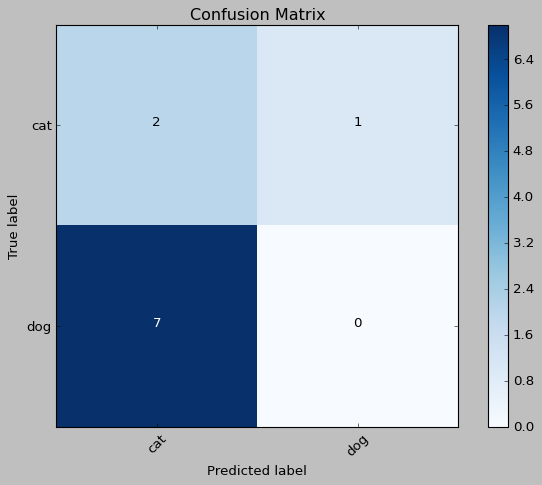

In [100]:
plot_confusion_matrix(pruned_model_3_cm, cm_plot_labels, title='Confusion Matrix')

In [52]:
pruned_model_3.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 54)      1512      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 54)      26298     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 118)     57466     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 118)     125434    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                 



*   **In the above code snippet of pruned_model_3 summary, Total params: 131,563,618**
*   **Total params in previous vgg16 new_model: 134,268,738**

*   **So by pruning here, accuracy dropped sharply and total params got reduced by 2,705,120 numbers.**







# **Scenario 4:**
## Now Removing 10 filters from all convolution layers containing 512 filters with least L1 Norm

In [74]:
surgeon2 = Surgeon(new_model)

for idx in range(7,13):
  surgeon2.add_job("delete_channels",conv_layers_list[idx],channels=conv_layer_dict[idx+1][:10])

pruned_model_4 = surgeon2.operate()
pruned_model_4.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Deleting 10/512 channels from layer: block4_conv1
Deleting 10/512 channels from layer: block4_conv2
Deleting 10/512 channels from layer: block4_conv3
Deleting 10/512 channels from layer: block5_conv1
Deleting 10/512 channels from layer: block5_conv2
Deleting 10/512 channels from layer: block5_conv3


In [75]:
pruned_model_4.save("pruned_model_4.h5") ## pruned vgg16 model

In [76]:
score = pruned_model_4.evaluate(test_batches)

20/20 [==============================] - 1s 62ms/step - loss: 0.3015 - accuracy: 0.8650


In [101]:
pruned_model_4_predictions = pruned_model_4.predict_generator(test_batches, steps=1, verbose=0)

In [102]:
pruned_model_4_cm = confusion_matrix(test_labels, np.round(pruned_model_4_predictions[:,0]))

Confusion matrix, without normalization
[[2 1]
 [3 4]]


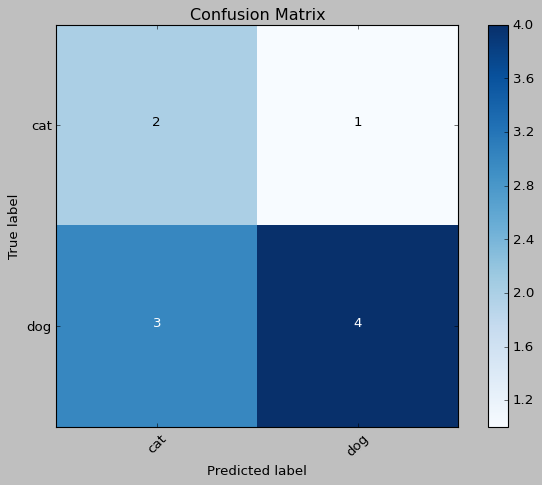

In [103]:
plot_confusion_matrix(pruned_model_4_cm, cm_plot_labels, title='Confusion Matrix')

In [77]:
pruned_model_4.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   multiple                



*   **In the above code snippet of pruned_model_4 summary, Total params: 131,782,298**
*   **Total params in previous vgg16 new_model: 134,268,738**

*   **So by pruning here, overall accuracy remained the same and total params got reduced by 2,486,440 numbers.**







In [61]:
!pip install hurry.filesize

In [78]:
import os
# Get file size in bytes for a given model
vgg16_new_model_size = os.stat('new_model.h5').st_size
pruned_model_1_size = os.stat('pruned_model_1.h5').st_size
pruned_model_2_size = os.stat('pruned_model_2.h5').st_size
pruned_model_3_size = os.stat('pruned_model_3.h5').st_size
pruned_model_4_size = os.stat('pruned_model_4.h5').st_size

In [79]:
print("vgg16 new model size in bytes: ",vgg16_new_model_size)
print("Pruned model 1 size in bytes: ",pruned_model_1_size)
print("Pruned model 2 size in bytes: ",pruned_model_2_size)
print("Pruned model 3 size in bytes: ",pruned_model_3_size)
print("Pruned model 4 size in bytes: ",pruned_model_4_size)

vgg16 new model size in bytes:  537223280
Pruned model 1 size in bytes:  537130824
Pruned model 2 size in bytes:  537106704
Pruned model 3 size in bytes:  526334984
Pruned model 4 size in bytes:  527209424


In [87]:
from hurry.filesize import size

print("vgg16 new model size in MB: ", size(vgg16_new_model_size))
print("Pruned model 1 size in MB: ", size(pruned_model_1_size))
print("Pruned model 2 size in MB: ", size(pruned_model_2_size))
print("Pruned model 3 size in MB: ", size(pruned_model_3_size))
print("Pruned model 4 size in MB: ", size(pruned_model_4_size))

vgg16 new model size in MB:  512M
Pruned model 1 size in MB:  512M
Pruned model 2 size in MB:  512M
Pruned model 3 size in MB:  501M
Pruned model 4 size in MB:  502M


In [106]:
analysis_dict = {}
analysis_dict['VGG16 New Model'] = {"Accuracy(Test Data)":"86.50%","Size(MB)":size(vgg16_new_model_size)}
analysis_dict['Pruned Model 1'] = {"Accuracy(Test Data)":"86.00%","Size(MB)":size(pruned_model_1_size)}
analysis_dict['Pruned Model 2'] = {"Accuracy(Test Data)":"85.00%","Size(MB)":size(pruned_model_2_size)}
analysis_dict['Pruned Model 3'] = {"Accuracy(Test Data)":"79.00%","Size(MB)":size(pruned_model_3_size)}
analysis_dict['Pruned Model 4'] = {"Accuracy(Test Data)":"86.50%","Size(MB)":size(pruned_model_4_size)}

In [114]:
import pandas as pd
analysis_df = pd.DataFrame.from_dict(analysis_dict,orient='index')

In [115]:
analysis_df

,Accuracy(Test Data),Size(MB)
VGG16 New Model,86.50%,512M
Pruned Model 1,86.00%,512M
Pruned Model 2,85.00%,512M
Pruned Model 3,79.00%,501M
Pruned Model 4,86.50%,502M
